In [1]:
import numpy as np
import matplotlib.pyplot as plt

The Frank-Tamm formula

$$ {\frac {d^{2}E}{dx\,d\omega }}={\frac {q^{2}}{4\pi }}\mu (\omega )\omega {\left(1-{\frac {c^{2}}{v^{2}n^{2}(\omega )}}\right)}$$

provided that $\beta ={\frac  {v}{c}}>{\frac  {1}{n(\omega )}}$. Here ${\mu (\omega )}$ and $n(\omega )$ are the frequency-dependent permeability and index of refraction of the medium respectively, $q$ is the electric charge of the particle, $v$ is the speed of the particle, and $c$ is the speed of light in vacuum.


Energy per unit length

$$ {\frac  {dE}{dx}}={\frac  {q^{2}}{4\pi }}\int _{{v>{\frac  {c}{n(\omega )}}}}\mu (\omega )\omega {\left(1-{\frac  {c^{2}}{v^{2}n^{2}(\omega )}}\right)}d\omega $$


Now say we have a ~GeV muon going through the a Outer Detector/Shield at SNOLAB (~13 m of water). Can we approximate the losses due to the Cherenkov effect negligable?

What about losses due to Bremsstrahlung? Let's ignore those, and also the compton scatterred electrons from them. 

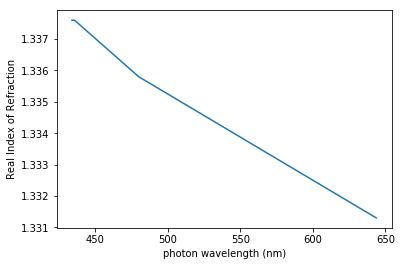

In [2]:
#In eV
energies = np.array([0.602, 0.689, 1.03,  1.926, 2.583, 2.845, 2.857, 3.124,3.457, 3.643, 3.812, 4.086, 4.511, 4.953, 5.474, 6.262, 7.000, 8.300, 10.00, 12.60])
#Refractive index
n = np.array([1.303, 1.3120,   1.3239,   1.3313, 1.3358, 1.3376, 1.3376, 1.3392, 1.3423, 1.3442, 1.3460, 1.3486, 1.3540, 1.3619, 1.3723, 1.3960, 1.3960, 1.3960,1.3960, 1.3960])

#plt.plot(energies, n)

wavelengths = 1239.8/energies

freq = 3e17/wavelengths

freq = freq[3:7]
wavelengths=wavelengths[3:7]
energies=energies[3:7]
n=n[3:7]

plt.plot(wavelengths, n)
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Real Index of Refraction')


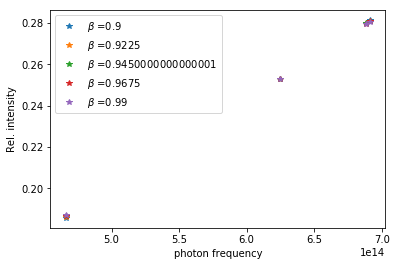

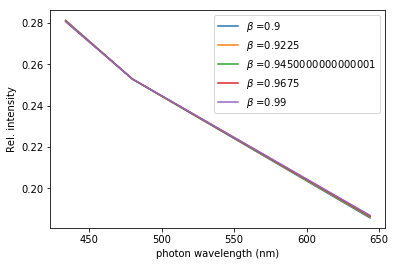

In [3]:
#I think mu(w) is constant in this range... So we can ignore the normalization then normalize later
b = np.linspace(0.9, 0.99, 5)



for beta in b:
    E_loss = 1.0/(4*np.pi) * freq*(1.0 - 1.0/(beta**2.0 * n**2.0))
    plt.plot(freq,E_loss/np.abs(E_loss.sum()), '*', label=r'$\beta$ ='+str(beta))
    
plt.xlabel('photon frequency')
plt.ylabel('Rel. intensity')
plt.legend()
plt.show()
for beta in b:
    E_loss = 1.0/(4*np.pi) * freq*(1.0 - 1.0/(beta**2.0 * n**2.0))
    plt.plot(wavelengths,E_loss/np.abs(E_loss.sum()), '-',label=r'$\beta$ ='+str(beta) )
    
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Rel. intensity')
plt.legend()

In [4]:
#Checking to see if our generated Cherenkov spectrum looks right.
freqSample = []
freqDensSpan=np.linspace(freq[0], freq[-1], 1000)
freqDens = np.interp(freqDensSpan, freq, E_loss)
freqDens = freqDens/np.abs(freqDens.sum())

#for i in range(10000):
#    freqSample.append(np.random.choice(np.linspace(freqDensSpan[0],freqDensSpan[-1], len(freqDens)),p=freqDens))
    
#plt.hist(freqSample)

And now to start the simulation set up...

In [5]:
#Geometery classes

class OuterDetector:
    def __init__(self, radius=655.0, height=1402.0): #in cm
        self.radius = radius
        self.height = height
        self.center = [0., 0., 0.]
        
class OuterCryostat:
    def __init__(self, OD,radius=223.0, centerOffset=0.): #in cm
        self.radius = radius
        self.position = OD.center
        self.position[2]+=centerOffset 
        
        
#OD = OuterDetector(radius=3200.0, height=1.0)
OD = OuterDetector()        

In [48]:
#Particle classes
mwe_depth = 6010.0 #SNOlab
lambdaa = 825.0 #at 6000 mwe

lowlim = 1e-3
uplim = 1.16
npoints = 100000
thetarad=np.linspace(lowlim, uplim, npoints)

MeiHime= np.cos(thetarad)*np.sin(thetarad)*( (8.60*1e-6)*np.exp(-(mwe_depth/1000)/(0.45*np.cos(thetarad)))+ (0.44*1e-6)*np.exp(-(mwe_depth/1000.0)/(0.87*np.cos(thetarad))) )/np.cos(thetarad)

MeiHime = MeiHime /np.sqrt(MeiHime.sum()**2.0)

GenDiscRad = 3200.0



class muon(object):
    def __init__(self, theta=0., phi=0., energy=1., position=np.array([0., 0., 2300.]), momentum=np.array([-1., 0., 0.])): #energy in GeV, it's mass in MeV
        self.theta = self.SetTheta()
        self.phi = np.random.sample()*np.pi*2.0 #Random number in [0,2pi]
        r = np.sqrt(np.random.sample())*GenDiscRad
        self.energy = energy
        self.position=position
        self.position[0]=np.sin(self.phi)*r#x position set by sin
        self.position[1]=np.cos(self.phi)*r #y position
        #print(self.position)
        self.momentum = np.array([-self.position[0], -self.position[1], 0.])
        self.momentum = self.momentum/np.sqrt(np.dot(self.momentum,self.momentum)) #normalize
        
        #Smear the phi of the vector by some amount (biasing WT)
        #phi_smear= np.random.sample()*2.0*np.pi*(np.random.sample())
        
        #above OD
        if((self.position[0]*self.position[0] + self.position[1]*self.position[1])<=OD.radius*OD.radius):
            phi_smear= np.random.sample()*2.0*np.pi
        else:
            phi_smear = np.arctan(OD.radius/np.sqrt(np.dot(position[:2], position[:2])) )*(2.0*np.random.sample()-1.0)
        c, s = np.cos(phi_smear), np.sin(phi_smear) #how much to smear by?
        ux, uy, uz = [0,0,1.0] #Need to rotate around z axis
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        self.momentum = R.dot(self.momentum)
        #rotate it downwards now by the amount self.theta (following muon angular distribution)
        #i.e. about the axis pxz (axis out of page/into page)
        ux, uy, uz = np.cross([0,0,1], self.momentum)
        rotateDown = np.pi/2.0 - self.theta
        c, s = np.cos(rotateDown), np.sin(rotateDown)
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        self.momentum = R.dot(self.momentum)
        

        #print(self.momentum)

    def GetBeta(self):
        gamma = self.energy/0.10566
        return np.sqrt(1.0 - 1.0/(gamma**2.0))

    def SetTheta(self):
        return np.random.choice(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)),p=MeiHime)
        
    

class cherenkov_photon:
    def __init__(self, parent):
        self.parent = parent
        #cosTheta = 1/nb 
        self.frequency = np.random.choice(np.linspace(freqDensSpan[0],freqDensSpan[-1], len(freqDens)),p=freqDens)
        self.thetaRel = self.SetThetaRelToParent(parent)
        position=parent.position
        self.momentum = parent.momentum
        #First, rotate relative to z axis by Cherenkov angle
        c, s = np.cos(self.thetaRel), np.sin(self.thetaRel) #cos and sine
        ux, uy, uz = np.cross(parent.momentum, [0,0,1.0]) #Need to rotate around axis out of page/into page
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        self.momentum = R.dot(self.momentum)
        #Now rotate random amount of phi about parent track
        phi=np.random.sample()*np.pi*2.0
        c, s = np.cos(phi), np.sin(phi) #cos and sine
        ux, uy, uz = parent.momentum[0], parent.momentum[1], parent.momentum[2]
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        self.momentum = R.dot(self.momentum)
        
        
        #print(parent.momentum)
        #print((180.0/np.pi)*np.arccos(np.dot(parent.momentum, self.momentum)))
        #print(180.0/np.pi * self.thetaRel)
        
    def SetThetaRelToParent(self,parent):
        return np.arccos(1.0/(self.GetRealIndex(self.frequency)*parent.GetBeta()))
        
    def GetRealIndex(self,frequency):
        return np.interp(self.frequency, freq, n)

In [49]:
#Testing
muon1 = muon()
muon2 = muon()


photon1= cherenkov_photon(muon1)
photon2= cherenkov_photon(muon1)
photon3= cherenkov_photon(muon1)
photon4=cherenkov_photon(muon2)
#print("Photons")
#print(muon2.theta*180/np.pi)
#print(np.dot(muon1.momentum, muon1.momentum))

thet_hist=[]
phi_hist=[]
z_hist=[]
for i in range(100): 
    muon2 = muon()
    thet_hist.append(muon2.theta*180/np.pi)
    phi_hist.append(muon2.phi*180/np.pi)
    z_hist.append(muon2.momentum[1])
#print(done)
#plt.hist(thet_hist) 
#plt.show()
#plt.hist(phi_hist)
#plt.show()
#plt.hist(z_hist)
#print(np.mean(thet_hist))
#print(muon2.momentum)


In [50]:
## OD = OuterDetector()

OC = OuterCryostat(OD)

#returns where on OC the particle hit it
def calc_intersect_OC(pos, mom):
    entry_set=False
    exit_set=False
    
    for t in range(2000000):
        point =pos+mom*t
        #print(np.sqrt(np.dot(point, point)))
        #print(OC.radius**2.0 -1.0 <=np.dot(point, point)<=OC.radius**2.0 +1.0)
        #print(OC.radius**2.0 -1.0 <=np.dot(point, point))
        #print(OC.radius**2.0 +1.0 >=np.dot(point, point))

        if( OC.radius-1.0<= np.sqrt(np.dot(point, point)) <= OC.radius+1.0):
            if(entry_set==False):
                entry=point
                entry_set=True
                #print('Entered OC')
                continue
            if(entry_set==True):
                exit=point
                exit_set=True
                #print('Exited OC')
                break
    if(entry_set ==True and exit_set==True):
        return entry, exit
    elif(point[2] < -OC.radius):
       #print("Does not intersect with OC")
        return False

def calc_intersect_OD(pos, mom):
    entry_set=False
    exit_set=False
    
    
    for t in range(20000000):
        point =pos+mom*t
        if(entry_set==True and exit_set==True): 
            return entry, exit
        #Intersection with roof
        if ((np.sqrt(np.dot(point[:2], point[:2]))<=OD.radius+1.0) and (OD.height/2.0 - 1.0<=point[2]<=OD.height/2.0 + 1.0)):
            entry=point
            entry_set=True
            #print('roof entry')
            continue
            #print(entry)
        #Intersection with walls
        if (entry_set==False):
            if (OD.radius-1.0 <=np.sqrt(np.dot(point[:2], point[:2]))<=OD.radius+1.0) and (-OD.height/2.0-1.<=point[2]<=OD.height/2.0+1.):
                entry=point
                entry_set=True
                #print('wall entry')
                continue
        if(OD.radius-1.0 <=np.sqrt(np.dot(point[:2], point[:2]))<=OD.radius+1.0) and (-OD.height/2.0 -1.0)<=point[2]<=(OD.height/2.0 +1.0):
            exit = point
            exit_set = True
            #print('wall exit')
            continue
        #Intersection with floor
        if ((np.sqrt(np.dot(point[:2], point[:2]))<=OD.radius +1.0) and (-OD.height/2.0 - 1.0<=point[2]<=-OD.height/2.0 + 1.0)):
            exit=point
            exit_set=True
            #print('floor exit')
            return entry, exit
        if(point[2]< (-OD.height/2.0 -1.0)):
            #print("Does not intersect with OD")
            return False

def calc_intersect_disc(pos, mom, height, radius):
    t = (height - pos[2])/mom[2] #z_pos + p_z*t = height
    x_new = pos[0]+mom[0]*t 
    y_new = pos[1]+mom[1]*t
    if( (x_new*x_new + y_new*y_new < radius*radius) and t>=0.):
        return np.array([x_new, y_new, pos[2]+mom[2]*t]) #intersection point
    else:
        return False

#(x+pxt)^2 + (y+pyt)^2 = r^2
#x^2 + (pxt)^2 + 2pxt*x + y^2 + (pyt)^2 + 2pyt*x = r^2
# (x^2 + y^2 - r^2) + 2(xpx + ypy)t + (py^2+px^2))t^2


def calc_intersect_wall(pos, mom):
    a = mom[0]*mom[0] + mom[1]*mom[1]
    b = 2.0*(pos[0]*mom[0]+pos[1]*mom[1])
    c = pos[0]*pos[0] + pos[1]*pos[1] - OD.radius*OD.radius
    discriminant = b*b - 4.0*a*c
    
    if (discriminant<0): #doesn't intersect cylinder walls
        #print("discriminated")
        return False
  
    #Solve quadratic equation for t+-, if these yield intersections inside z range, keep
    t_pl = (-b + np.sqrt(discriminant))/(2.0*a)
    t_min = (-b - np.sqrt(discriminant))/(2.0*a)
    
    #print(t_min, t_pl)
    #print(pos+t_min*mom, pos+t_pl*mom)
    
    if(t_min<=0 and t_pl <=0):
        return False
    
    if (-OD.height/2.0<pos[2]<OD.height/2.0): #particle inside OD, take positive solution
        if(t_min>=0): #forward in time 
            x_new = pos[0]+mom[0]*t_min 
            y_new = pos[1]+mom[1]*t_min
            z_new = pos[2]+mom[2]*t_min
            return np.array([x_new, y_new, z_new])
        elif(t_pl>0): #unnecessary but safe
            x_new = pos[0]+mom[0]*t_pl
            y_new = pos[1]+mom[1]*t_pl
            z_new = pos[2]+mom[2]*t_pl
            return np.array([x_new, y_new, z_new])
        else:
            #print("Inside OD, what's going on with wall intersect?")
            return False
    
    #Cases for outside OD.
    z_new_min = pos[2]+t_min*mom[2]
    z_new_pl = pos[2]+t_pl*mom[2]
        
    if (t_min>=0 and t_pl>=0): # forward in time
        if((-OD.height/2.0<z_new_min<OD.height/2.0) and (-OD.height/2.0<z_new_pl<OD.height/2.0)):
            x_new = pos[0]+mom[0]*t_min
            y_new = pos[1]+mom[1]*t_min
            z_new = pos[2]+mom[2]*t_min
            entry = np.array([x_new, y_new, z_new])
            x_new = pos[0]+mom[0]*t_pl
            y_new = pos[1]+mom[1]*t_pl
            z_new = pos[2]+mom[2]*t_pl
            exit = np.array([x_new, y_new, z_new])
            return entry, exit
        
    if(t_min>=0 and (-OD.height/2.0<z_new_min<OD.height/2.0)):
        x_new = pos[0]+mom[0]*t_min 
        y_new = pos[1]+mom[1]*t_min
        return np.array([x_new, y_new, z_new_min])
    if(t_pl>=0 and (-OD.height/2.0<z_new_pl<OD.height/2.0)): #forward in time
        x_new = pos[0]+mom[0]*t_pl 
        y_new = pos[1]+mom[1]*t_pl
        return np.array([x_new, y_new, z_new_pl])

    return False
    
        
def calc_intersect_OD2(pos, mom): #Make use of quadratic equations and be more efficient
    entry_set, exit_set = False, False
    
    outside_start = pos[2]>OD.height/2. #particle is above OD
    
    if(outside_start == False): #photon etc...created inside OD.
        if mom[2]<0:
            floor_intersect = calc_intersect_disc(pos, mom, -OD.height/2., OD.radius)
        elif mom[2]>0:
            roof_intersect = calc_intersect_disc(pos, mom, OD.height/2., OD.radius)
        if(type(floor_intersect) != bool):
            return floor_intersect
        elif(type(roof_intersect) != bool):
            return roof_intersect
        else: #photon hits wall somewhere
            return calc_intersect_wall(pos, mom)
                

    if(outside_start):#check roof/floor first as these are fast
        #print("1")

        roof_intersect = calc_intersect_disc(pos, mom, OD.height/2., OD.radius)
        floor_intersect = calc_intersect_disc(pos, mom, -OD.height/2., OD.radius)
        
        if((pos[0]*pos[0] + pos[1]*pos[1] - OD.radius*OD.radius)<=0 and type(roof_intersect)==bool): #within radius upon start
            #print("2")
            return False #Can't intersect cylinder if misses roof in this case 
        
        elif(type(roof_intersect)!=bool):#hits roof
            entry = roof_intersect
            entry_set = True
            #print("roof")
            if(type(floor_intersect) != bool): #entered roof, exitted floor
                #print("roof and floor")
                return entry, floor_intersect #we are done! Lucky.
            else:#entered roof, exits wall
                #print("roof and wall")
                return entry, calc_intersect_wall(pos,mom)
                       
        elif(type(floor_intersect) != bool and type(roof_intersect)==bool): #didn't enter roof, but did exit floor
            exit = floor_intersect
            exit_set = True
            #print("wall and floor")
            #print(calc_intersect_wall(pos,mom), exit)
            if(type(calc_intersect_wall(pos,mom)) == bool):
                return False
            #Now there's only one option, it entered through the walls
            return calc_intersect_wall(pos,mom), exit
        else:#Only other option, it entered and exitted via the walls or missed the entire thing
            #print("7")
            #print(calc_intersect_wall(pos, mom))
            return calc_intersect_wall(pos, mom)
            


In [51]:
#Testing
muon1 = muon()
        
#print('about to while...')
while(calc_intersect_OD2(muon1.position, muon1.momentum) == False):
    #print('while..')
    muon1=muon()

#calc_intersect_OC(muon1.position, muon1.momentum)
#calc_intersect_OD(muon1.position, muon1.momentum)


#np.sqrt(muon1.position[0]**2 + muon1.position[1]**2)
#muon1.momentum


Each PMT is 8" or 20.3 cm. Let's make the wall cells now... 

How many in a column from ground to the top of the OD height? Around the circumeference?

In [52]:
CellSize = 20.32
NumCellsHeight = np.round(OD.height/CellSize)
NumCellsCircum = np.round((OD.radius*2.0*np.pi)/CellSize)

print("Cells in height:", NumCellsHeight)
print("Cells in circumeference:", NumCellsCircum)

        
class WallCells:
    def __init__(self, CellSize): #in cm
        self.CellSize = CellSize
        self.data = [[0 for i in range(int(NumCellsCircum))] for j in range(int(NumCellsHeight))]
    
    def hit(self,intersection, NumPhotons=1):
        #Find what bin to add to
        #if (((intersection[0]**2.0 + intersection[1]**2.0) != OD.radius**2.0) or (-OD.height/2.0 <= intersection[2] <= OD.height/2.0)==False):
        #    print("Doesn't intersect with wall")
        #    return
        heightBin = np.round((intersection[2]+OD.height/2.0)/OD.height *  69.0)
        phiBin = np.round(np.arctan(intersection[1]/intersection[0])/(2.0*np.pi) * (203.0 - 101.0))
        self.data[phiBin][heightBin] +=NumPhotons


('Cells in height:', 69.0)
('Cells in circumeference:', 203.0)


In [53]:
#%%timeit
mu=muon()
numEvents = 10000
entries=np.zeros((numEvents, 3))
exits=np.zeros((numEvents, 3))
startingPos=np.zeros((numEvents, 3))
thetas=np.zeros(numEvents)
thetas2=np.zeros(numEvents)
phis=np.zeros(numEvents)

for ev in range(numEvents):
    if(ev%100==0): 
        print("iteration",ev)
        
    while(type(calc_intersect_OD2(mu.position, mu.momentum)) == (bool or None)):
        #print(type(calc_intersect_OD2(mu.position, mu.momentum)))
        mu=muon()


    #print(mu.position, mu.momentum)
    entries[ev][:]=calc_intersect_OD2(mu.position, mu.momentum)[0]
    exits[ev][:]=calc_intersect_OD2(mu.position, mu.momentum)[1]
    thetas[ev]=np.arccos(np.dot(mu.momentum, [0.,0.,-1.]))
    thetas2[ev]=mu.theta
    phis[ev]=mu.phi
    startingPos[ev][:]=mu.position
    
    #wall.hit(calc_intersect_OD2(mu.position, mu.momentum)[0], 1)
    #wall.hit(calc_intersect_OD2(mu.position, mu.momentum)[1], -1)
    
    mu=muon()



('iteration', 0)
('iteration', 100)
('iteration', 200)
('iteration', 300)
('iteration', 400)
('iteration', 500)
('iteration', 600)
('iteration', 700)
('iteration', 800)
('iteration', 900)
('iteration', 1000)
('iteration', 1100)
('iteration', 1200)
('iteration', 1300)
('iteration', 1400)
('iteration', 1500)
('iteration', 1600)
('iteration', 1700)
('iteration', 1800)
('iteration', 1900)
('iteration', 2000)
('iteration', 2100)
('iteration', 2200)
('iteration', 2300)
('iteration', 2400)
('iteration', 2500)
('iteration', 2600)
('iteration', 2700)
('iteration', 2800)
('iteration', 2900)
('iteration', 3000)
('iteration', 3100)
('iteration', 3200)
('iteration', 3300)
('iteration', 3400)
('iteration', 3500)
('iteration', 3600)
('iteration', 3700)
('iteration', 3800)
('iteration', 3900)
('iteration', 4000)
('iteration', 4100)
('iteration', 4200)
('iteration', 4300)
('iteration', 4400)
('iteration', 4500)
('iteration', 4600)
('iteration', 4700)
('iteration', 4800)
('iteration', 4900)
('iteration'

<IPython.core.display.Javascript object>


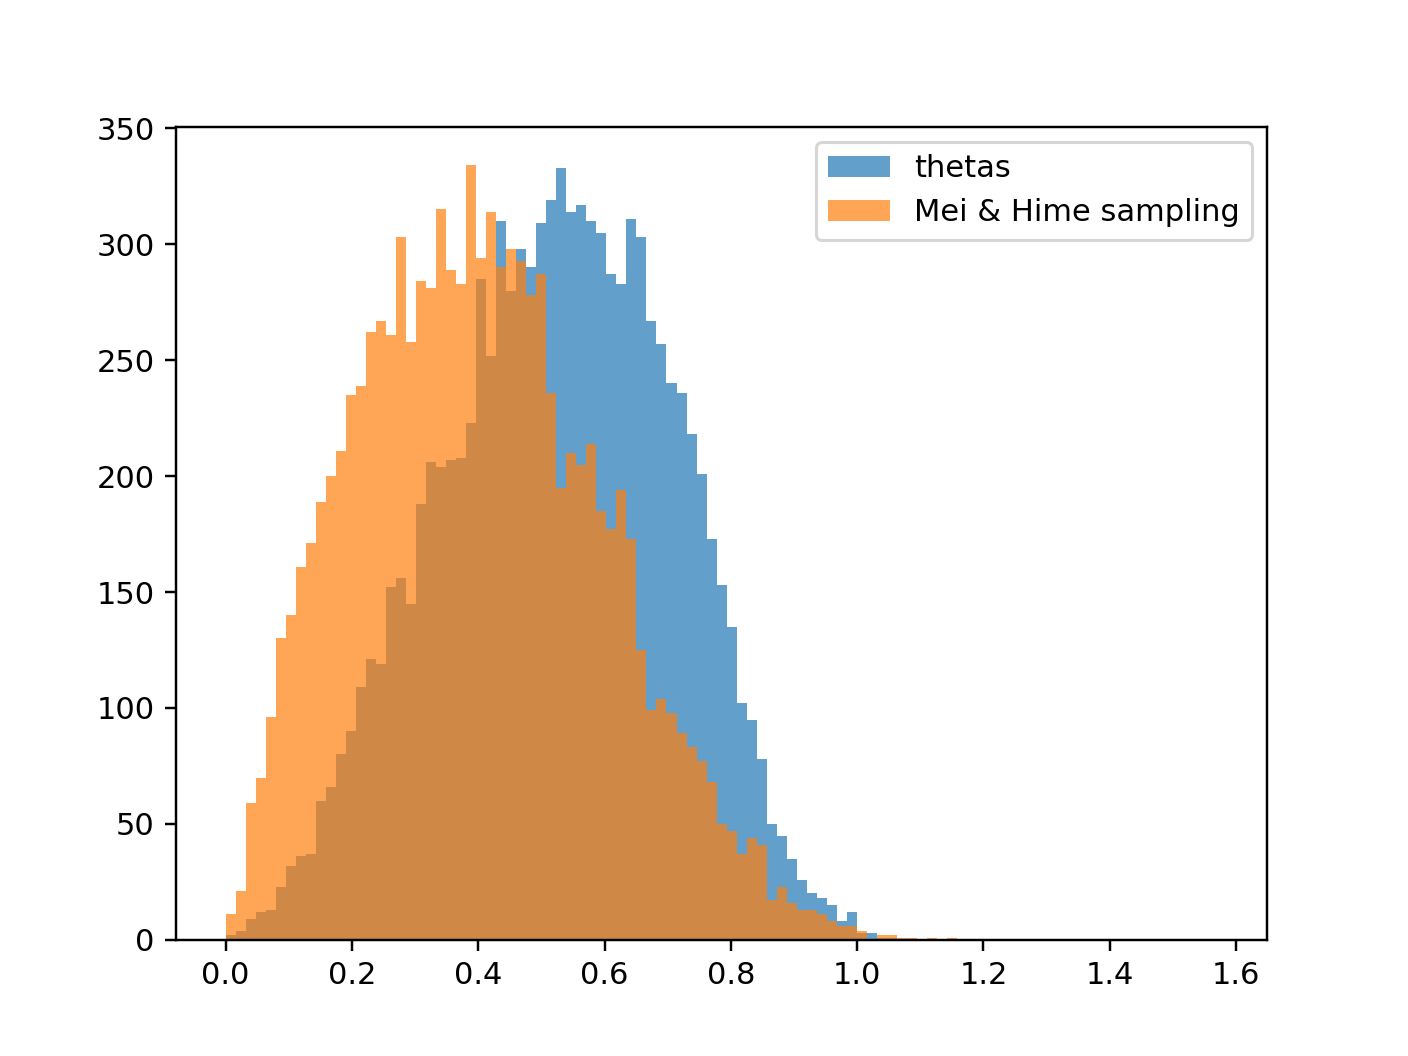

In [54]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
ax.scatter(entries[:,0],entries[:,1],entries[:,2], label='entry points', alpha=0.6, s=0.5)
ax.scatter(exits[:,0],exits[:,1],exits[:,2], label='exit points', alpha=0.6, s=0.5)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
plt.legend()
plt.show()
plt.ion()
#plt.savefig("enteries_exits_10k_discSameAsODradius.pdf")


In [20]:
#%%timeit
MeiHime_sample=np.zeros(numEvents)
for i in range(numEvents):
    MeiHime_sample[i]=np.random.choice(np.linspace(thetarad[0],thetarad[-1], len(MeiHime)),p=MeiHime)
    

In [55]:
plt.clf()
#plt.hist(phis, bins=np.linspace(0, 2.0*np.pi, 100), label='phis', alpha=0.7)
plt.hist(thetas2, bins=np.linspace(0,np.pi/2.0, 100), label='thetas', alpha=0.7)
plt.hist(MeiHime_sample, bins=np.linspace(0,np.pi/2.0, 100), label='Mei & Hime sampling', alpha=0.7)
plt.legend()
plt.show()
#plt.savefig("normal_OD_doubleGenR.pdf")
print("Mean, std of thetas: ",np.mean(thetas2), np.std(thetas2))

('Mean, std of thetas: ', 0.5245956137321374, 0.18350868570889298)


In [219]:
#('Mean, std of thetas: ', 0.5245956137321374, 0.18350868570889298) 
#('Mean, std of thetas: ', 0.5419516500325003, 0.19671899941536863) #double genR

#plt.scatter(startingPos[:,0], startingPos[:,1], alpha=0.25)
plt.hist(np.sqrt(startingPos[:,0]**2.0 + startingPos[:,1]**2.0))

(array([ 182.,  584., 1531., 1950., 1833., 1500., 1012.,  714.,  460.,
         234.]),
 array([   6.34981553,  365.68030948,  725.01080342, 1084.34129737,
        1443.67179131, 1803.00228526, 2162.3327792 , 2521.66327315,
        2880.99376709, 3240.32426104, 3599.65475498]),
 <a list of 10 Patch objects>)